## Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Import And Preprocess Data Set

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Smith and Thopte CE397Proj/CO2/FinalCo2.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert Effective date type to datetime
df["Date"] = pd.to_datetime(df["Date"])
# df['DATE'] = pd.to_datetime(df['DATE']).dt.tz_localize(None)
df.head(2)

,Date,Value
0,1959-03-01,316.65
1,1959-04-01,317.72


In [ ]:
df.tail()

,Date,Value
777,2023-12-01,421.86
778,2024-01-01,422.80
779,2024-02-01,424.62
780,2024-03-01,425.38
781,2024-04-01,426.57


In [ ]:
df=df.loc[df['Date']>='2000-01-01']

In [ ]:
df.set_index('Date', inplace=True)

df.head()

,Value
Date,
2000-01-01,369.45
2000-02-01,369.71
2000-03-01,370.75
2000-04-01,371.98
2000-05-01,371.74


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292 entries, 2000-01-01 to 2024-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   292 non-null    float64
dtypes: float64(1)
memory usage: 4.6 KB


In [ ]:
train = df[:190]
valid = df[190:250]
test = df[250:]

scaler = MinMaxScaler()

# Fit scaler on training data and transform all subsets
train_data = scaler.fit_transform(train[['Value']])
validate_data = scaler.transform(valid[['Value']])
test_data = scaler.transform(test[['Value']])

print("Train data size:", len(train_data))
print("Validation data size:", len(validate_data))
print("Test data size:", len(test_data))


Train data size: 190
Validation data size: 60
Test data size: 42


In [ ]:
from keras.layers import Bidirectional
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10 # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_val,y_val=create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Implemented Code

## Grid Search for Best Activation and Optimizer

### Subtask:
Implement a grid search to find the best combination of activation function and optimizer for the CNN model.

**Reasoning**:
Define a function to create, compile, and train a CNN model with specified activation and optimizer.

In [ ]:
def create_train_cnn_model_grid_search(activation_function, optimizer_name):
    """
    Creates, compiles, and trains a CNN model with the specified activation function and optimizer.

    Args:
        activation_function: The activation function to use in the model layers.
        optimizer_name: The name of the optimizer to use ('adam', 'adamw', or 'adamax').

    Returns:
        A tuple containing the trained Keras model and its training history.
    """
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation=activation_function, input_shape=(seq_length, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation=activation_function))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation=activation_function))
    model.add(Dense(1)) # Linear activation for regression

    if optimizer_name == 'adam':
        optimizer = optimizers.Adam()
    elif optimizer_name == 'adamw':
        optimizer = optimizers.AdamW()
    elif optimizer_name == 'adamax':
        optimizer = optimizers.Adamax()
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}. Choose from 'adam', 'adamw', or 'adamax'.")


    model.compile(optimizer=optimizer, loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])

    return model, history

**Reasoning**:
Perform a grid search by iterating through all combinations of activation functions and optimizers, training a model for each, and storing the evaluation results.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import sqrt

activation_functions = ['sigmoid', 'tanh', 'relu', 'leaky_relu', 'silu', 'gelu']
optimizers_list = ['adam', 'adamw', 'adamax']
num_trials = 5 # Number of trials for each combination
grid_search_results = {}

for activation in activation_functions:
    grid_search_results[activation] = {}
    for optimizer_name in optimizers_list:
        grid_search_results[activation][optimizer_name] = []

for trial in range(num_trials):
    print(f"--- Starting Grid Search Trial {trial + 1}/{num_trials} ---")
    for activation in activation_functions:
        for optimizer_name in optimizers_list:
            print(f"Training model with {activation} activation and {optimizer_name} optimizer for Trial {trial + 1}...")
            model, history = create_train_cnn_model_grid_search(activation, optimizer_name)

            # Evaluate the model
            test_predict = model.predict(X_test)
            test_predict = scaler.inverse_transform(test_predict)
            y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

            test_mse = mean_squared_error(y_test_inv, test_predict)
            test_rmse = sqrt(test_mse)
            test_mae = mean_absolute_error(y_test_inv, test_predict)

            # Calculate average test error for this trial and combination
            average_error = (test_mse + test_rmse + test_mae) / 3

            # Store the result
            grid_search_results[activation][optimizer_name].append(average_error)

            print(f"Finished training and evaluating model with {activation} activation and {optimizer_name} optimizer for Trial {trial + 1}.")

print("\n--- Grid Search completed ---")

--- Starting Grid Search Trial 1/5 ---
Training model with sigmoid activation and adam optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Finished training and evaluating model with sigmoid activation and adam optimizer for Trial 1.
Training model with sigmoid activation and adamw optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Finished training and evaluating model with sigmoid activation and adamw optimizer for Trial 1.
Training model with sigmoid activation and adamax optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Finished training and evaluating model with sigmoid activation and adamax optimizer for Trial 1.
Training model with tanh activation and adam optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Finished training and evaluating model with tanh activation and adam optimizer for Trial 1.
Training model with tanh activation and adamw optimizer for Trial 1...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Finished training and evaluating model with tanh activation and adamw optimizer for Trial 1.
Training model with tanh activation and adamax optimizer for Trial 1...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Finished training and evaluating model with tanh activation and adamax optimizer for Trial 1.
Training model with relu activation and adam optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Finished training and evaluating model with relu activation and adam optimizer for Trial 1.
Training model with relu activation and adamw optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Finished training and evaluating model with relu activation and adamw optimizer for Trial 1.
Training model with relu activation and adamax optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Finished training and evaluating model with relu activation and adamax optimizer for Trial 1.
Training model with leaky_relu activation and adam optimizer for Trial 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Finished training and evaluating model with leaky_relu activation and adam optimizer for Trial 1.
Training model with leaky_relu activation and adam

In [ ]:
average_grid_search_results = {}
for activation in activation_functions:
    average_grid_search_results[activation] = {}
    for optimizer_name in optimizers_list:
        average_error = sum(grid_search_results[activation][optimizer_name]) / num_trials
        average_grid_search_results[activation][optimizer_name] = average_error

# Find the best combination
best_combination = None
min_average_error = float('inf')

for activation, optimizer_results in average_grid_search_results.items():
    for optimizer_name, average_error in optimizer_results.items():
        if average_error < min_average_error:
            min_average_error = average_error
            best_combination = (activation, optimizer_name)

print("Average error for each combination across all trials:")
for activation, optimizer_results in average_grid_search_results.items():
    for optimizer_name, average_error in optimizer_results.items():
        print(f"  {activation} + {optimizer_name}: {average_error:.4f}")

print(f"\nThe best combination of activation function and optimizer is: {best_combination}")
print(f"With an average error of: {min_average_error:.4f}")

Average error for each combination across all trials:
  sigmoid + adam: 42.2419
  sigmoid + adamw: 98.8024
  sigmoid + adamax: 163.0987
  tanh + adam: 4.6198
  tanh + adamw: 5.0346
  tanh + adamax: 9.0189
  relu + adam: 1.4730
  relu + adamw: 1.2494
  relu + adamax: 1.5477
  leaky_relu + adam: 1.2075
  leaky_relu + adamw: 1.1975
  leaky_relu + adamax: 1.7102
  silu + adam: 1.1484
  silu + adamw: 1.1720
  silu + adamax: 3.8955
  gelu + adam: 1.1813
  gelu + adamw: 1.1143
  gelu + adamax: 4.6315

The best combination of activation function and optimizer is: ('gelu', 'adamw')
With an average error of: 1.1143


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Best Model Performance Metrics:
  Test MSE: 2.0281
  Test RMSE: 1.4241
  Test MAE: 1.2214
  Test R²: 0.8041
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


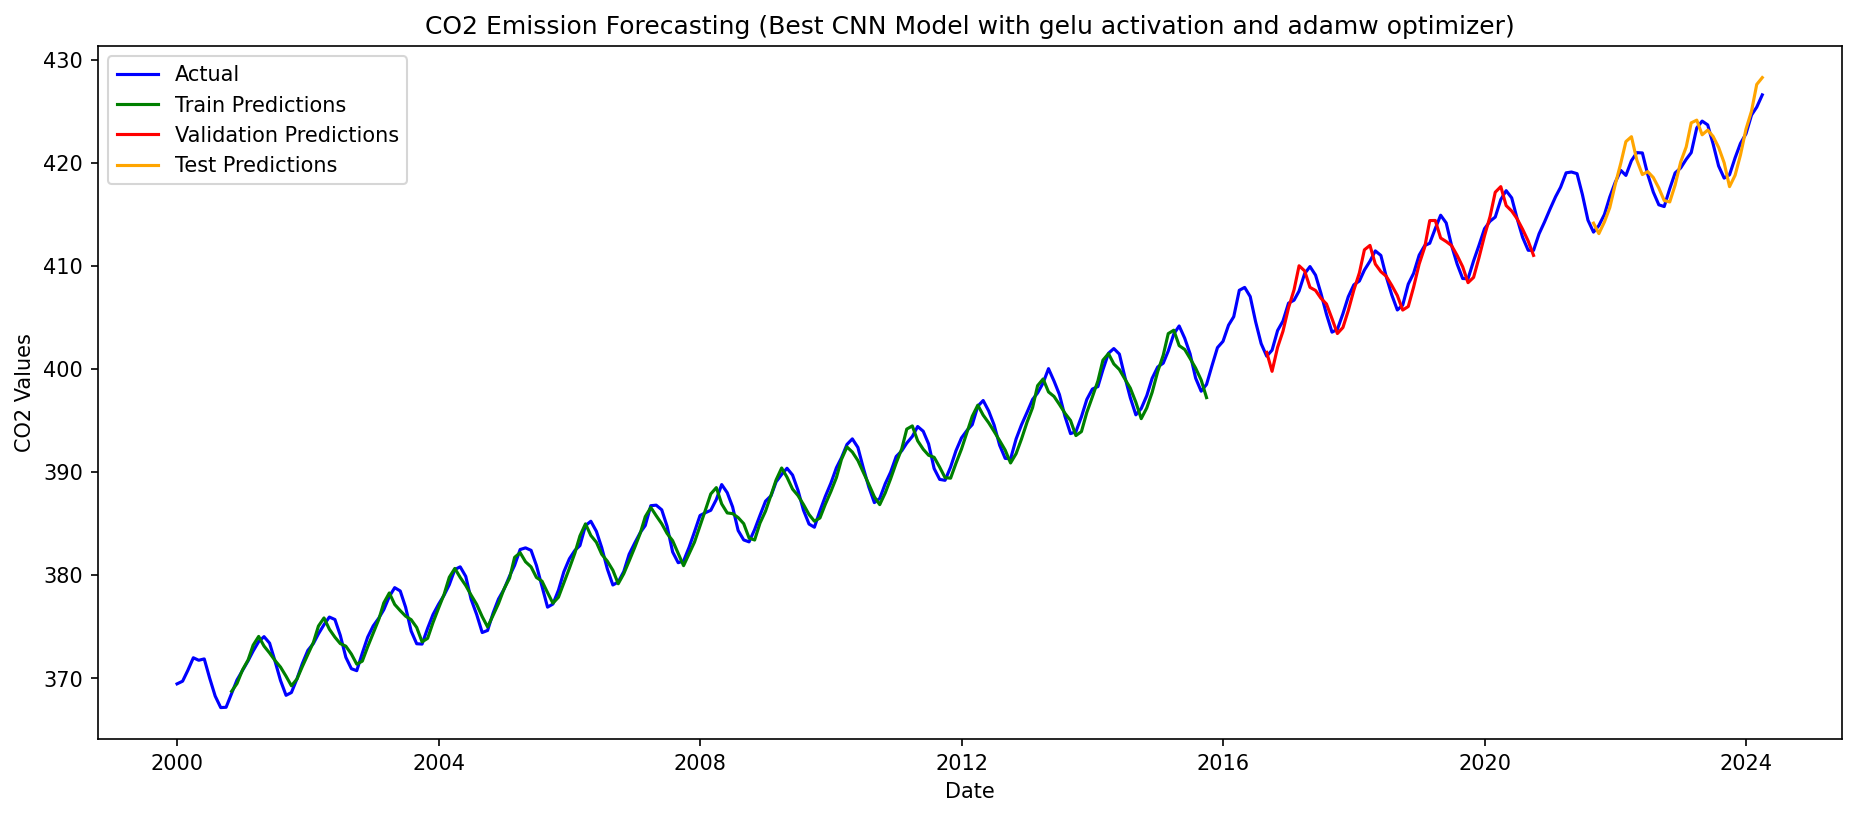

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import sqrt

# Train the final model using the best combination
best_activation, best_optimizer = best_combination
best_model, best_history = create_train_cnn_model_grid_search(best_activation, best_optimizer)

# Evaluate the best model
test_predict_best = best_model.predict(X_test)

# Inverse transform the predictions and actual values
test_predict_best_inv = scaler.inverse_transform(test_predict_best)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics for the best model
best_test_mse = mean_squared_error(y_test_inv, test_predict_best_inv)
best_test_rmse = sqrt(best_test_mse)
best_test_mae = mean_absolute_error(y_test_inv, test_predict_best_inv)
best_test_r2 = r2_score(y_test_inv, test_predict_best_inv)

# Print the metrics for the best model
print("Best Model Performance Metrics:")
print(f"  Test MSE: {best_test_mse:.4f}")
print(f"  Test RMSE: {best_test_rmse:.4f}")
print(f"  Test MAE: {best_test_mae:.4f}")
print(f"  Test R²: {best_test_r2:.4f}")

# Plotting
plt.figure(figsize=(15, 6), dpi=150)

# Plot actual values
plt.plot(df.index, df['Value'], label='Actual', color='blue')

# Generate and plot training predictions for the best model
train_predict_best = best_model.predict(X_train)
train_predict_best_inv = scaler.inverse_transform(train_predict_best)
# Adjust the index for training predictions
plt.plot(df.index[seq_length : len(train) ], train_predict_best_inv.flatten(), label='Train Predictions', color='green')

# Generate and plot validation predictions for the best model
val_predict_best = best_model.predict(X_val)
val_predict_best_inv = scaler.inverse_transform(val_predict_best)
# Adjust the index for validation predictions
plt.plot(df.index[len(train) + seq_length : len(train) + len(valid)], val_predict_best_inv.flatten(), label='Validation Predictions', color='red')


# Plot test predictions (already calculated)
# Adjust the index for test predictions
plt.plot(df.index[len(train) + len(valid) + seq_length : len(df)], test_predict_best_inv.flatten(), label='Test Predictions', color='orange')

plt.title(f'CO2 Emission Forecasting (Best CNN Model with {best_activation} activation and {best_optimizer} optimizer)')
plt.xlabel('Date')
plt.ylabel('CO2 Values')
plt.legend(loc='upper left')
plt.show()

# DeepONet

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Multiply, Add

# Define m, the number of latent features, consistent with the Dense layer sizes.
m = 128

# Define the input for the branch network (X_train shape)
branch_input = Input(shape=(seq_length, 1), name='branch_input')

# Define the input for the trunk network (single prediction point)
trunk_input = Input(shape=(1,), name='trunk_input')

In [ ]:

# 1. Build the branch network
x = Flatten()(branch_input)
for _ in range(3):
    x = Dense(m, activation=best_activation)(x)
branch_output = x

# 2. Build the trunk network
y = trunk_input
for _ in range(3):
    y = Dense(m, activation=best_activation)(y)
trunk_output = y

# 3. Combine the branch and trunk networks
# Element-wise multiplication
merged_output = Multiply()([branch_output, trunk_output])

# Final output layer
output = Dense(1)(merged_output)  # Linear activation for regression

# 4. Create the DeepONet model
deeponet_model = Model(inputs=[branch_input, trunk_input], outputs=output)

# 5. Select and compile the optimizer
if best_optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam()
elif best_optimizer == 'adamw':
    optimizer = tf.keras.optimizers.AdamW()
elif best_optimizer == 'adamax':
    optimizer = tf.keras.optimizers.Adamax()
else:
    raise ValueError(f"Unsupported optimizer: {best_optimizer}. Choose from 'adam', 'adamw', or 'adamax'.")

deeponet_model.compile(optimizer=optimizer, loss='mse')

# 6. Print the deeponet_model.summary()
print(deeponet_model.summary())

Model: "functional_637"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ branch_input        │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_91          │ (None, 10)        │          0 │ branch_input[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trunk_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_182 (Dense)   │ (None, 128)       │      1,408 │ flatten_91[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_185 (Dense)   │ (None, 128)       │        256 │ trunk_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_183 (Dense)   │ (None, 128)       │     16,512 │ dense_182[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_186 (Dense)   │ (None, 128)       │     16,512 │ dense_185[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_184 (Dense)   │ (None, 128)       │     16,512 │ dense_183[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_187 (Dense)   │ (None, 128)       │     16,512 │ dense_186[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128)       │          0 │ dense_184[0][0],  │
│                     │                   │            │ dense_187[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_188 (Dense)   │ (None, 1)         │        129 │ multiply[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,841 (265.00 KB)

 Trainable params: 67,841 (265.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
y_train_trunk = np.zeros((X_train.shape[0], 1))
y_val_trunk = np.zeros((X_val.shape[0], 1))
y_test_trunk = np.zeros((X_test.shape[0], 1))

print(f"Shape of y_train_trunk: {y_train_trunk.shape}")
print(f"Shape of y_val_trunk: {y_val_trunk.shape}")
print(f"Shape of y_test_trunk: {y_test_trunk.shape}")

Shape of y_train_trunk: (180, 1)
Shape of y_val_trunk: (50, 1)
Shape of y_test_trunk: (32, 1)


In [ ]:
early_stopping_deeponet = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)

history_deeponet = deeponet_model.fit(
    [X_train, y_train_trunk], y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_val, y_val_trunk], y_val),
    callbacks=[early_stopping_deeponet],
    verbose=0
)

print("DeepONet model training complete.")

DeepONet model training complete.


**Reasoning**:
Now that the DeepONet model has been trained, the next step is to evaluate its performance on the test data. This involves making predictions, inverse transforming them, and calculating relevant metrics like MSE, RMSE, MAE, and R-squared to understand how well the model generalizes.



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import sqrt

# Evaluate the DeepONet model on the test data
deeponet_test_predict = deeponet_model.predict([X_test, y_test_trunk])

# Inverse transform the predictions and actual values to original scale
deeponet_test_predict_inv = scaler.inverse_transform(deeponet_test_predict)
y_test_inv_deeponet = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics for the DeepONet model
deeponet_test_mse = mean_squared_error(y_test_inv_deeponet, deeponet_test_predict_inv)
deeponet_test_rmse = sqrt(deeponet_test_mse)
deeponet_test_mae = mean_absolute_error(y_test_inv_deeponet, deeponet_test_predict_inv)
deeponet_test_r2 = r2_score(y_test_inv_deeponet, deeponet_test_predict_inv)

# Print the metrics for the DeepONet model
print("DeepONet Model Performance Metrics:")
print(f"  Test MSE: {deeponet_test_mse:.4f}")
print(f"  Test RMSE: {deeponet_test_rmse:.4f}")
print(f"  Test MAE: {deeponet_test_mae:.4f}")
print(f"  Test R²: {deeponet_test_r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
DeepONet Model Performance Metrics:
  Test MSE: 0.2749
  Test RMSE: 0.5243
  Test MAE: 0.4178
  Test R²: 0.9735


## Visualize DeepONet Model Results

### Subtask:
Visualize the actual vs. predicted values for the DeepONet model on the entire dataset.

**Reasoning**:
Plot the actual CO2 values, along with the DeepONet's predictions for the training, validation, and test sets, to visually assess its forecasting performance over time.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


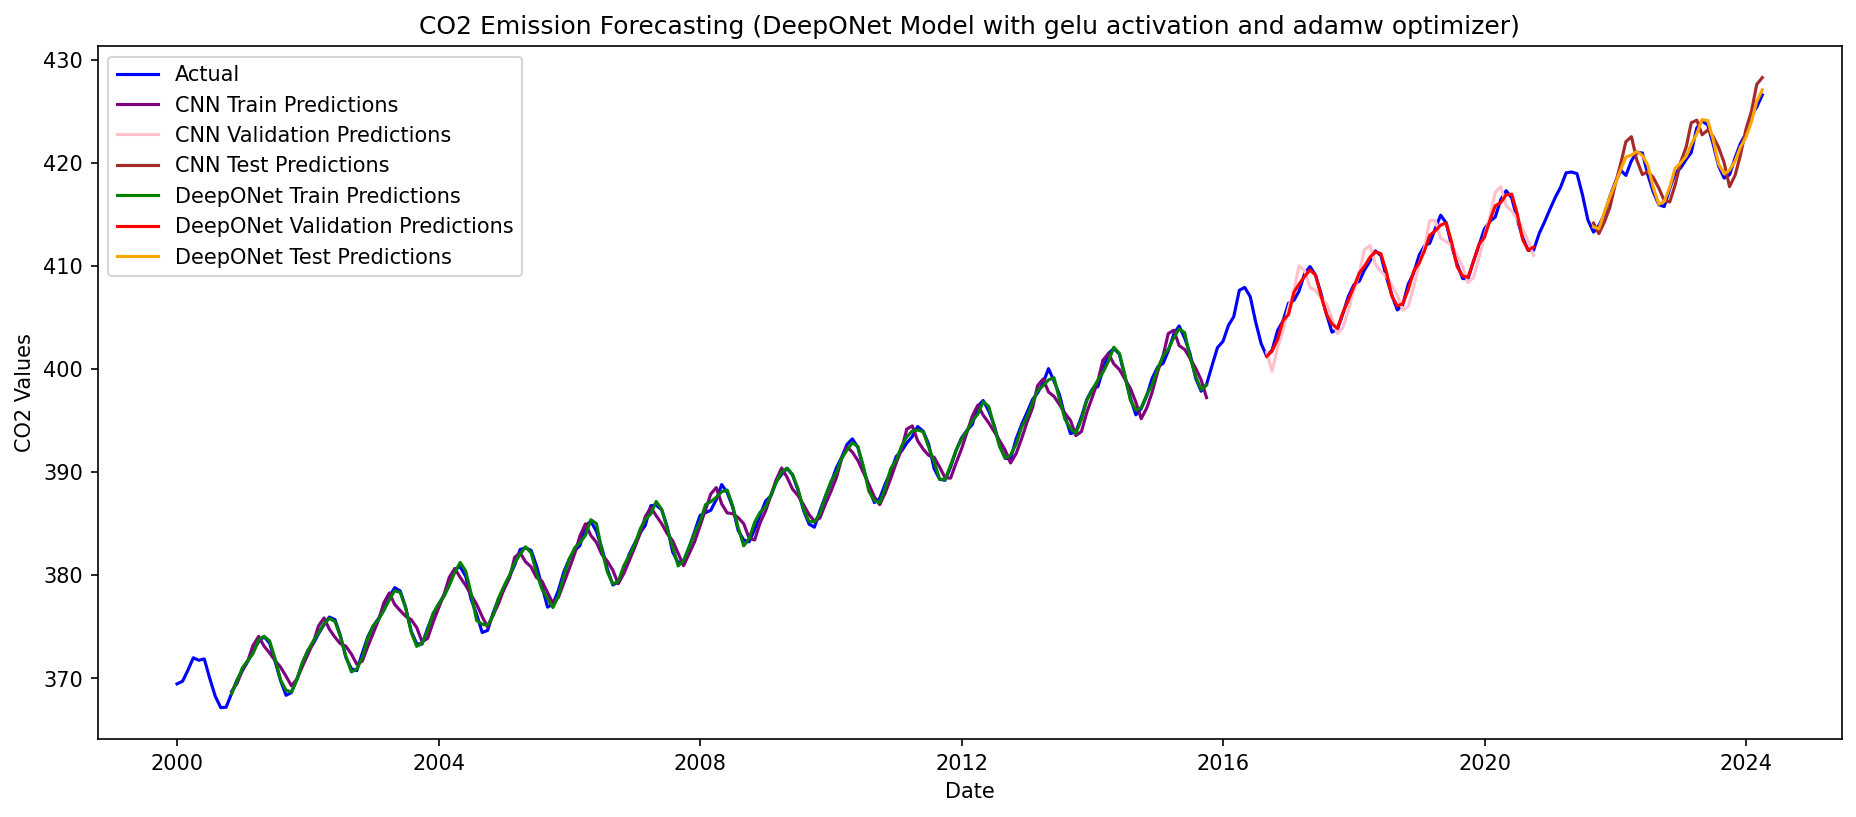

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)

# Plot actual values
plt.plot(df.index, df['Value'], label='Actual', color='blue')
### CNN Vals
plt.plot(df.index[seq_length : len(train) ], train_predict_best_inv.flatten(), label='CNN Train Predictions', color='purple')
val_predict_best = best_model.predict(X_val)
val_predict_best_inv = scaler.inverse_transform(val_predict_best)
plt.plot(df.index[len(train) + seq_length : len(train) + len(valid)], val_predict_best_inv.flatten(), label='CNN Validation Predictions', color='pink')
plt.plot(df.index[len(train) + len(valid) + seq_length : len(df)], test_predict_best_inv.flatten(), label='CNN Test Predictions', color='brown')

# Generate and plot training predictions for the DeepONet model
deeponet_train_predict = deeponet_model.predict([X_train, y_train_trunk])
deeponet_train_predict_inv = scaler.inverse_transform(deeponet_train_predict)
# Adjust the index for training predictions
plt.plot(df.index[seq_length : len(train)], deeponet_train_predict_inv.flatten(), label='DeepONet Train Predictions', color='green')

# Generate and plot validation predictions for the DeepONet model
deeponet_val_predict = deeponet_model.predict([X_val, y_val_trunk])
deeponet_val_predict_inv = scaler.inverse_transform(deeponet_val_predict)
# Adjust the index for validation predictions
plt.plot(df.index[len(train) + seq_length : len(train) + len(valid)], deeponet_val_predict_inv.flatten(), label='DeepONet Validation Predictions', color='red')

# Plot test predictions (already calculated)
# Adjust the index for test predictions
plt.plot(df.index[len(train) + len(valid) + seq_length : len(df)], deeponet_test_predict_inv.flatten(), label='DeepONet Test Predictions', color='orange')



plt.title(f'CO2 Emission Forecasting (DeepONet Model with {best_activation} activation and {best_optimizer} optimizer)')
plt.xlabel('Date')
plt.ylabel('CO2 Values')
plt.legend(loc='upper left')
plt.show()

## Compare Model Performance


In [ ]:
import pandas as pd

# Create a dictionary to store the performance metrics for both models
metrics_data = {
    'CNN Model': {
        'MSE': best_test_mse,
        'RMSE': best_test_rmse,
        'MAE': best_test_mae,
        'R²': best_test_r2
    },
    'DeepONet Model': {
        'MSE': deeponet_test_mse,
        'RMSE': deeponet_test_rmse,
        'MAE': deeponet_test_mae,
        'R²': deeponet_test_r2
    }
}

# Convert the dictionary into a pandas DataFrame
performance_comparison_df = pd.DataFrame(metrics_data)

# Print the DataFrame to display the comparison table
print(performance_comparison_df)

      CNN Model  DeepONet Model
MSE    2.028069        0.274852
RMSE   1.424103        0.524263
MAE    1.221395        0.417816
R²     0.804111        0.973452


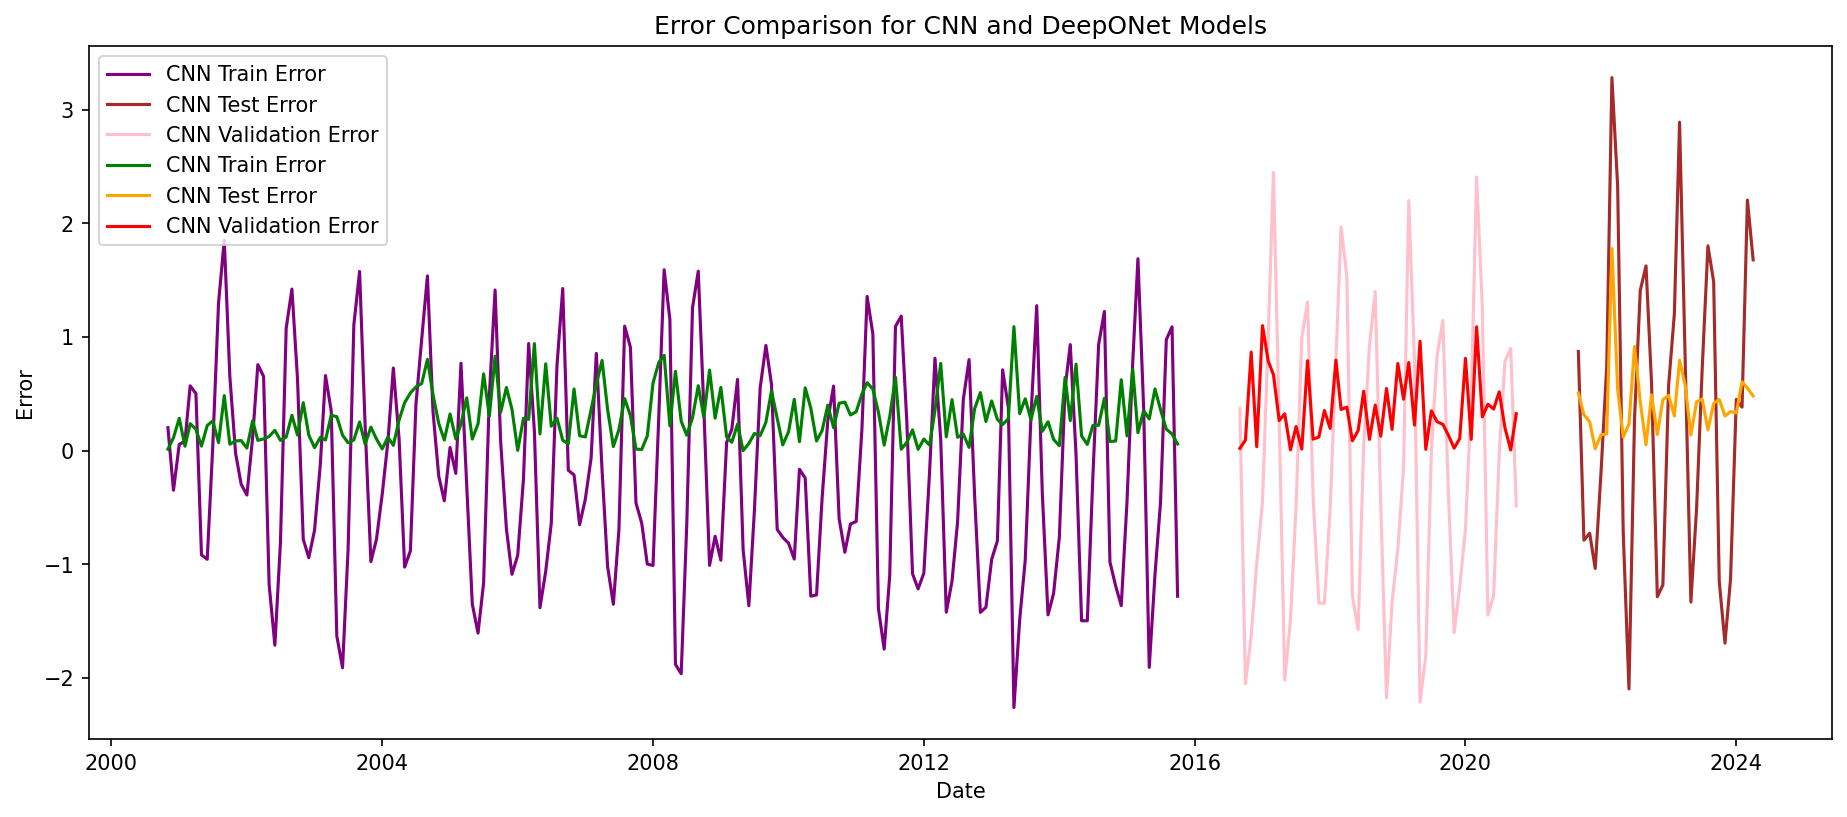

In [ ]:
y_train_inv = scaler.inverse_transform(y_train)
y_val_inv = scaler.inverse_transform(y_val)
# y_test_inv is already defined from previous cells


plt.figure(figsize=(15, 6), dpi=150)

# Error throughout CNN (already correctly uses y_test_inv)
cnn_error_test = test_predict_best_inv - y_test_inv
cnn_error_train = train_predict_best_inv - y_train_inv
cnn_error_val = val_predict_best_inv - y_val_inv

plt.plot(df.index[seq_length : len(train)], cnn_error_train.flatten(), label='CNN Train Error', color='purple')
plt.plot(df.index[len(train) + len(valid) + seq_length : len(df)], cnn_error_test.flatten(), label='CNN Test Error', color='brown')
plt.plot(df.index[len(train) + seq_length : len(train) + len(valid)], cnn_error_val.flatten(), label='CNN Validation Error', color='pink')


# Error throughout DeepONet
deeponet_error_val = np.abs(deeponet_val_predict_inv - y_val_inv)
deeponet_error_test = np.abs(deeponet_test_predict_inv - y_test_inv)
deeponet_error_train = np.abs(deeponet_train_predict_inv - y_train_inv)

plt.plot(df.index[seq_length : len(train)], deeponet_error_train.flatten(), label='CNN Train Error', color='green')
plt.plot(df.index[len(train) + len(valid) + seq_length : len(df)], deeponet_error_test.flatten(), label='CNN Test Error', color='orange')
plt.plot(df.index[len(train) + seq_length : len(train) + len(valid)], deeponet_error_val.flatten(), label='CNN Validation Error', color='red')

plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Comparison for CNN and DeepONet Models')
plt.legend(loc='upper left')

plt.show()